In [1]:
## Python
import os
import random
import sys
import warnings
warnings.filterwarnings('ignore')


## Package
import glob 
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import scipy.io.wavfile
import tensorflow as tf
py.init_notebook_mode(connected=True)


## Keras
from keras import regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras.utils import to_categorical

from keras.models import Model, Sequential
from keras import optimizers
from keras.layers import Input, Conv1D, Conv2D,BatchNormalization, MaxPooling1D,MaxPooling2D, LSTM, Dense, Activation, Layer,Reshape

from keras.utils import to_categorical
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model


## Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


## Rest
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm_notebook as tqdm


from hmmlearn import hmm

input_duration=3
# % pylab inline

Using TensorFlow backend.


### RAVDESS DATASET

In [2]:
# Data Directory
# Please edit according to your directory change.
Ravdess_paths= np.array(("E:/NYU_Classes/Project/Ravdess_Audio_Speech_Actors_01-24/","E:/NYU_Classes/Project/Ravdess_Audio_Song_Actors_01-24/"))
dir_list = os.listdir(Ravdess_paths[0])
dir_list.sort()
print (dir_list)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [3]:
# Create DataFrame for Data intel
ravdess_db = pd.DataFrame(columns=['path','source','actor', 'gender', 'emotion','emotion_lb'])
count = 0
for data_path in Ravdess_paths:
    dir_list = os.listdir(data_path)
    dir_list.sort()
    for i in dir_list:
        file_list = os.listdir(data_path + i)
        for f in file_list:
            nm = f.split('.')[0].split('-')
            path = data_path + i + '/' + f
            src = int(nm[1])
            actor = int(nm[-1])
            emotion = int(nm[2])
            source = "Ravdess"

            if int(actor)%2 == 0:
                gender = "female"
            else:
                gender = "male"

            if nm[3] == '01':
                intensity = 0
            else:
                intensity = 1

            if nm[4] == '01':
                statement = 0
            else:
                statement = 1

            if nm[5] == '01':
                repeat = 0
            else:
                repeat = 1

            if emotion == 1:
                lb = "neutral"
            elif emotion == 2:
                lb = "calm"
            elif emotion == 3:
                lb = "happy"
            elif emotion == 4:
                lb = "sad"
            elif emotion == 5:
                lb = "angry"
            elif emotion == 6:
                lb = "fearful"
            elif emotion == 7:
                lb = "disgust"
            elif emotion == 8:
                lb = "surprised"
            else:
                lb = "none"

            ravdess_db.loc[count] = [path,source,actor, gender, emotion,lb]
            count += 1

In [4]:
ravdess_db.head()

,path,source,actor,gender,emotion,emotion_lb
0,E:/NYU_Classes/Project/Ravdess_Audio_Speech_Ac...,Ravdess,1,male,1,neutral
1,E:/NYU_Classes/Project/Ravdess_Audio_Speech_Ac...,Ravdess,1,male,1,neutral
2,E:/NYU_Classes/Project/Ravdess_Audio_Speech_Ac...,Ravdess,1,male,1,neutral
3,E:/NYU_Classes/Project/Ravdess_Audio_Speech_Ac...,Ravdess,1,male,1,neutral
4,E:/NYU_Classes/Project/Ravdess_Audio_Speech_Ac...,Ravdess,1,male,2,calm


In [5]:
ravdess_db['split'] =  np.where((ravdess_db.actor ==23) | (ravdess_db.actor ==24), 'Test', 
                                (np.where((ravdess_db.actor ==21) | (ravdess_db.actor ==22),'Val','Train')))

In [6]:
ravdess_db['split'].value_counts()

Train    2036
Test      208
Val       208
Name: split, dtype: int64

#### Changing Calm to Neutral and Removing Surprised to Make it into 6 classs prediction

In [7]:
ravdess_db.drop(ravdess_db.index[ravdess_db['emotion_lb'] == 'surprised'], inplace = True)
ravdess_db.loc[ravdess_db.emotion_lb=='calm',['emotion','emotion_lb']]= 1,'neutral'

In [8]:
ravdess_db.emotion_lb.value_counts()

neutral    564
angry      376
happy      376
fearful    376
sad        376
disgust    192
Name: emotion_lb, dtype: int64

#### 6 Class Prediction

In [11]:
dataset_db = ravdess_db.copy()

In [11]:
#dataset_db.emotion_lb = dataset_db.gender+"_"+dataset_db.emotion_lb

In [12]:
dataset_db.head()

,path,source,actor,gender,emotion,emotion_lb,split
0,E:/NYU_Classes/Project/Ravdess_Audio_Speech_Ac...,Ravdess,1,male,1,neutral,Train
1,E:/NYU_Classes/Project/Ravdess_Audio_Speech_Ac...,Ravdess,1,male,1,neutral,Train
2,E:/NYU_Classes/Project/Ravdess_Audio_Speech_Ac...,Ravdess,1,male,1,neutral,Train
3,E:/NYU_Classes/Project/Ravdess_Audio_Speech_Ac...,Ravdess,1,male,1,neutral,Train
4,E:/NYU_Classes/Project/Ravdess_Audio_Speech_Ac...,Ravdess,1,male,1,neutral,Train


In [13]:
dataset_db.emotion_lb.value_counts()

neutral    564
angry      376
happy      376
fearful    376
sad        376
disgust    192
Name: emotion_lb, dtype: int64

In [14]:
modelling_db = dataset_db[(dataset_db.split=='Train') | (dataset_db.split =='Val')]

In [15]:
modelling_db.index = range(len(modelling_db.index))

In [16]:
modelling_db.shape

(2068, 7)

In [17]:
emotions = sorted(set(dataset_db.emotion_lb))
emotions

['angry', 'disgust', 'fearful', 'happy', 'neutral', 'sad']

In [18]:
audio_duration = 3
sampling_rate = 44100
input_length = sampling_rate * audio_duration
n_mfcc = 20


In [19]:
data_sample = np.zeros(input_length)
n_fft = int(sampling_rate * 0.01)   # window length: 0.01 s
hop_length = n_fft // 2  # usually one specifies the hop length as a fraction of the window length
mfccs = librosa.feature.mfcc(y=data_sample, sr=sampling_rate, n_mfcc=20,hop_length=hop_length, n_fft=n_fft).T
mfccs.shape

(602, 20)

In [20]:
class HMMTrainer(object):
    def __init__(self, model_name='GaussianHMM', n_components=4, cov_type='diag', n_iter=1000):
        self.model_name = model_name
        self.n_components = n_components
        self.cov_type = cov_type
        self.n_iter = n_iter
        self.models = []
        if self.model_name == 'GaussianHMM':
            self.model = hmm.GaussianHMM(n_components=self.n_components,covariance_type=self.cov_type,n_iter=self.n_iter)
        else:
            raise TypeError('Invalid model type') 

    def train(self, X):
        np.seterr(all='ignore')
        self.models.append(self.model.fit(X))
        # Run the model on input data
    def get_score(self, input_data):
        return self.model.score(input_data)

In [21]:
hmm_models = []
for emotion in tqdm(emotions):
    model_emo_db = modelling_db[modelling_db.emotion_lb==emotion]
    model_emo_db.index = range(len(model_emo_db.index))
    audios = np.array([])
    
    for i in tqdm(range(len(model_emo_db))):
        signal, sample_rate = librosa.load(model_emo_db.path[i], res_type='kaiser_fast',sr=22050*2)
        signal,index = librosa.effects.trim(signal,top_db = 25)
        signal = scipy.signal.wiener(signal)

        if len(signal) > input_length:
            signal = signal[0:input_length]
        elif  input_length > len(signal):
            max_offset = input_length - len(signal)  
            signal = np.pad(signal, (0, max_offset), "constant")

        MFCC = librosa.feature.mfcc(signal, sr=sampling_rate, n_mfcc=n_mfcc)

        if len(audios) == 0:
            audios = MFCC
        else:
            audios = np.append(audios, MFCC, axis=0)  
    
    print('audios.shape =', audios.shape)
    # Train and save HMM model
    hmm_trainer = HMMTrainer(n_components=12)
    hmm_trainer.train(audios)
    hmm_models.append((hmm_trainer, emotion))
    hmm_trainer = None
    print('model trained for ',emotion)


audios.shape = (6880, 259)
model trained for  angry



audios.shape = (3520, 259)
model trained for  disgust



audios.shape = (6880, 259)
model trained for  fearful



audios.shape = (6880, 259)
model trained for  happy



audios.shape = (10320, 259)
model trained for  neutral



audios.shape = (6880, 259)
model trained for  sad



In [23]:
test_db = dataset_db[(dataset_db.split=='Test')]
test_db.index = range(len(test_db.index))
test_db.shape

(192, 7)

In [133]:
signal, sample_rate = librosa.load(test_db.path[0], res_type='kaiser_fast',sr=22050*2)
signal,index = librosa.effects.trim(signal,top_db = 25)
signal = scipy.signal.wiener(signal)

if len(signal) > input_length:
    signal = signal[0:input_length]
elif  input_length > len(signal):
    max_offset = input_length - len(signal)  
    signal = np.pad(signal, (0, max_offset), "constant")

MFCC = librosa.feature.mfcc(signal, sr=sampling_rate, n_mfcc=n_mfcc)

In [134]:
for i in range(len(hmm_models)):
    model = hmm_models[i][0]
    score = model.get_score(MFCC)
    print(score)

-12202.627440655495
-10908.924763368861
-11468.075147943282
-8008.438900894003
-9255.499633706528
-9855.592742679992


In [24]:
test_db_prediction = []

for i in tqdm(range(len(test_db))):
    signal, sample_rate = librosa.load(test_db.path[i], res_type='kaiser_fast',sr=22050*2)
    signal,index = librosa.effects.trim(signal,top_db = 25)
    signal = scipy.signal.wiener(signal)

    if len(signal) > input_length:
        signal = signal[0:input_length]
    elif  input_length > len(signal):
        max_offset = input_length - len(signal)  
        signal = np.pad(signal, (0, max_offset), "constant")

    MFCC = librosa.feature.mfcc(signal, sr=sampling_rate, n_mfcc=n_mfcc)
    max_score = -9999999999999999999
    output_label = None
    for item in hmm_models:
        hmm_model, label = item
        score = hmm_model.get_score(MFCC)
        if score > max_score:
            max_score = score
            output_label = label
    test_db_prediction.append(output_label)


In [25]:
test_db_prediction[0:10]

['happy',
 'happy',
 'disgust',
 'happy',
 'happy',
 'neutral',
 'fearful',
 'neutral',
 'angry',
 'fearful']

In [26]:
Prediction_DF = pd.DataFrame({'predictedvalues': test_db_prediction})
Prediction_DF[0:10]

,predictedvalues
0,happy
1,happy
2,disgust
3,happy
4,happy
5,neutral
6,fearful
7,neutral
8,angry
9,fearful


In [27]:
Actual_DF = pd.DataFrame({'actualvalues': test_db.emotion_lb})
Actual_DF[0:10]

,actualvalues
0,neutral
1,neutral
2,neutral
3,neutral
4,neutral
5,neutral
6,neutral
7,neutral
8,neutral
9,neutral


In [28]:
finaldf = pd.concat([Actual_DF,Prediction_DF],axis=1)
finaldf

,actualvalues,predictedvalues
0,neutral,happy
1,neutral,happy
2,neutral,disgust
3,neutral,happy
4,neutral,happy
...,...,...
187,fearful,happy
188,fearful,happy
189,fearful,angry
190,fearful,angry


In [29]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
angry,32
disgust,16
fearful,32
happy,32
neutral,48
sad,32


In [30]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
angry,23
disgust,57
fearful,6
happy,71
neutral,27
sad,8


In [31]:
from sklearn.metrics import accuracy_score
y_true = finaldf.actualvalues
y_pred = finaldf.predictedvalues
accuracy_score(y_true, y_pred)*100

23.4375

In [32]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average='macro') *100

21.730154705014883

In [33]:
from sklearn.metrics import confusion_matrix
c_matrix = confusion_matrix(y_true, y_pred)
c_matrix

array([[10, 12,  0,  9,  0,  1],
       [ 2,  7,  0,  7,  0,  0],
       [ 5, 10,  1, 15,  0,  1],
       [ 5, 11,  0, 13,  2,  1],
       [ 1, 10,  4, 20, 11,  2],
       [ 0,  7,  1,  7, 14,  3]], dtype=int64)

In [34]:
class_names = sorted(set(finaldf.actualvalues))

Text(0.5, 33.0, 'Predicted label')

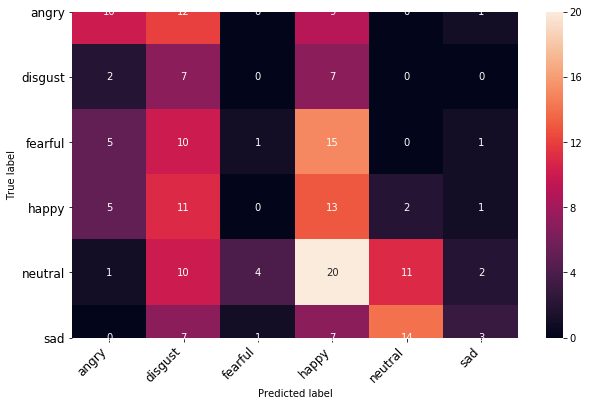

In [35]:
df_cm = pd.DataFrame(c_matrix, index=class_names, columns=class_names)

plt.figure(figsize=(10,6))
try:
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
except ValueError:
    raise ValueError("Confusion matrix values must be integers.")


heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=12)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=12)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [39]:
import pickle
filename = 'E:/NYU_Classes/Project/Models/Ravdess_6class_HMM.sav'
pickle.dump(hmm_models, open(filename, 'wb'))

# 12 Class Prediction

In [44]:
dataset_db.emotion_lb = dataset_db.gender+"_"+dataset_db.emotion_lb

In [45]:
dataset_db.head()

,path,source,actor,gender,emotion,emotion_lb,split
0,E:/NYU_Classes/Project/Ravdess_Audio_Speech_Ac...,Ravdess,1,male,1,male_neutral,Train
1,E:/NYU_Classes/Project/Ravdess_Audio_Speech_Ac...,Ravdess,1,male,1,male_neutral,Train
2,E:/NYU_Classes/Project/Ravdess_Audio_Speech_Ac...,Ravdess,1,male,1,male_neutral,Train
3,E:/NYU_Classes/Project/Ravdess_Audio_Speech_Ac...,Ravdess,1,male,1,male_neutral,Train
4,E:/NYU_Classes/Project/Ravdess_Audio_Speech_Ac...,Ravdess,1,male,1,male_neutral,Train


In [46]:
dataset_db.emotion_lb.value_counts()

male_neutral      288
female_neutral    276
male_happy        192
male_sad          192
male_angry        192
male_fearful      192
female_fearful    184
female_angry      184
female_sad        184
female_happy      184
female_disgust     96
male_disgust       96
Name: emotion_lb, dtype: int64

In [47]:
modelling_db = dataset_db[(dataset_db.split=='Train') | (dataset_db.split =='Val')]

In [48]:
modelling_db.index = range(len(modelling_db.index))

In [49]:
modelling_db.shape

(2068, 7)

In [50]:
emotions = sorted(set(dataset_db.emotion_lb))
emotions

['female_angry',
 'female_disgust',
 'female_fearful',
 'female_happy',
 'female_neutral',
 'female_sad',
 'male_angry',
 'male_disgust',
 'male_fearful',
 'male_happy',
 'male_neutral',
 'male_sad']

In [51]:
audio_duration = 3
sampling_rate = 44100
input_length = sampling_rate * audio_duration
n_mfcc = 20


In [52]:
data_sample = np.zeros(input_length)
n_fft = int(sampling_rate * 0.01)   # window length: 0.01 s
hop_length = n_fft // 2  # usually one specifies the hop length as a fraction of the window length
mfccs = librosa.feature.mfcc(y=data_sample, sr=sampling_rate, n_mfcc=20,hop_length=hop_length, n_fft=n_fft).T
mfccs.shape

(602, 20)

In [53]:
class HMMTrainer(object):
    def __init__(self, model_name='GaussianHMM', n_components=4, cov_type='diag', n_iter=1000):
        self.model_name = model_name
        self.n_components = n_components
        self.cov_type = cov_type
        self.n_iter = n_iter
        self.models = []
        if self.model_name == 'GaussianHMM':
            self.model = hmm.GaussianHMM(n_components=self.n_components,covariance_type=self.cov_type,n_iter=self.n_iter)
        else:
            raise TypeError('Invalid model type') 

    def train(self, X):
        np.seterr(all='ignore')
        self.models.append(self.model.fit(X))
        # Run the model on input data
    def get_score(self, input_data):
        return self.model.score(input_data)

In [54]:
hmm_models = []
for emotion in tqdm(emotions):
    model_emo_db = modelling_db[modelling_db.emotion_lb==emotion]
    model_emo_db.index = range(len(model_emo_db.index))
    audios = np.array([])
    
    for i in tqdm(range(len(model_emo_db))):
        signal, sample_rate = librosa.load(model_emo_db.path[i], res_type='kaiser_fast',sr=22050*2)
        signal,index = librosa.effects.trim(signal,top_db = 25)
        signal = scipy.signal.wiener(signal)

        if len(signal) > input_length:
            signal = signal[0:input_length]
        elif  input_length > len(signal):
            max_offset = input_length - len(signal)  
            signal = np.pad(signal, (0, max_offset), "constant")

        MFCC = librosa.feature.mfcc(signal, sr=sampling_rate, n_mfcc=n_mfcc)

        if len(audios) == 0:
            audios = MFCC
        else:
            audios = np.append(audios, MFCC, axis=0)  
    
    print('audios.shape =', audios.shape)
    # Train and save HMM model
    hmm_trainer = HMMTrainer(n_components=12)
    hmm_trainer.train(audios)
    hmm_models.append((hmm_trainer, emotion))
    hmm_trainer = None
    print('model trained for ',emotion)


audios.shape = (3360, 259)
model trained for  female_angry



audios.shape = (1760, 259)
model trained for  female_disgust



audios.shape = (3360, 259)
model trained for  female_fearful



audios.shape = (3360, 259)
model trained for  female_happy



audios.shape = (5040, 259)
model trained for  female_neutral



audios.shape = (3360, 259)
model trained for  female_sad



audios.shape = (3520, 259)
model trained for  male_angry



audios.shape = (1760, 259)
model trained for  male_disgust



audios.shape = (3520, 259)
model trained for  male_fearful



audios.shape = (3520, 259)
model trained for  male_happy



audios.shape = (5280, 259)
model trained for  male_neutral



audios.shape = (3520, 259)
model trained for  male_sad



In [55]:
test_db = dataset_db[(dataset_db.split=='Test')]
test_db.index = range(len(test_db.index))
test_db.shape

(192, 7)

In [56]:
signal, sample_rate = librosa.load(test_db.path[0], res_type='kaiser_fast',sr=22050*2)
signal,index = librosa.effects.trim(signal,top_db = 25)
signal = scipy.signal.wiener(signal)

if len(signal) > input_length:
    signal = signal[0:input_length]
elif  input_length > len(signal):
    max_offset = input_length - len(signal)  
    signal = np.pad(signal, (0, max_offset), "constant")

MFCC = librosa.feature.mfcc(signal, sr=sampling_rate, n_mfcc=n_mfcc)

In [57]:
for i in range(len(hmm_models)):
    model = hmm_models[i][0]
    score = model.get_score(MFCC)
    print(score)

-10577.51627552162
-9248.233295629005
-9255.591691247033
-8610.057916152164
-8821.316266335873
-8303.35701009183
-11019.970712958464
-10823.621772695149
-11850.04986824484
-8342.17513233245
-9401.578518158914
-10271.627442086596


In [58]:
test_db_prediction = []

for i in tqdm(range(len(test_db))):
    signal, sample_rate = librosa.load(test_db.path[i], res_type='kaiser_fast',sr=22050*2)
    signal,index = librosa.effects.trim(signal,top_db = 25)
    signal = scipy.signal.wiener(signal)

    if len(signal) > input_length:
        signal = signal[0:input_length]
    elif  input_length > len(signal):
        max_offset = input_length - len(signal)  
        signal = np.pad(signal, (0, max_offset), "constant")

    MFCC = librosa.feature.mfcc(signal, sr=sampling_rate, n_mfcc=n_mfcc)
    max_score = -9999999999999999999
    output_label = None
    for item in hmm_models:
        hmm_model, label = item
        score = hmm_model.get_score(MFCC)
        if score > max_score:
            max_score = score
            output_label = label
    test_db_prediction.append(output_label)


In [59]:
test_db_prediction[0:10]

['female_sad',
 'female_sad',
 'male_happy',
 'male_happy',
 'male_happy',
 'male_sad',
 'male_angry',
 'male_neutral',
 'male_fearful',
 'male_fearful']

In [60]:
Prediction_DF = pd.DataFrame({'predictedvalues': test_db_prediction})
Prediction_DF[0:10]

,predictedvalues
0,female_sad
1,female_sad
2,male_happy
3,male_happy
4,male_happy
5,male_sad
6,male_angry
7,male_neutral
8,male_fearful
9,male_fearful


In [61]:
Actual_DF = pd.DataFrame({'actualvalues': test_db.emotion_lb})
Actual_DF[0:10]

,actualvalues
0,male_neutral
1,male_neutral
2,male_neutral
3,male_neutral
4,male_neutral
5,male_neutral
6,male_neutral
7,male_neutral
8,male_neutral
9,male_neutral


In [62]:
finaldf = pd.concat([Actual_DF,Prediction_DF],axis=1)
finaldf

,actualvalues,predictedvalues
0,male_neutral,female_sad
1,male_neutral,female_sad
2,male_neutral,male_happy
3,male_neutral,male_happy
4,male_neutral,male_happy
...,...,...
187,female_fearful,female_angry
188,female_fearful,female_angry
189,female_fearful,male_fearful
190,female_fearful,male_angry


In [63]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
female_angry,16
female_disgust,8
female_fearful,16
female_happy,16
female_neutral,24
female_sad,16
male_angry,16
male_disgust,8
male_fearful,16


In [64]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,20
female_disgust,24
female_fearful,5
female_happy,17
female_neutral,9
female_sad,31
male_angry,10
male_fearful,5
male_happy,57


In [65]:
from sklearn.metrics import accuracy_score
y_true = finaldf.actualvalues
y_pred = finaldf.predictedvalues
accuracy_score(y_true, y_pred)*100

21.354166666666664

In [66]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average='macro') *100

17.94542886744504

In [69]:
from sklearn.metrics import confusion_matrix
c_matrix = confusion_matrix(y_true, y_pred)
c_matrix

array([[ 2,  6,  0,  0,  1,  3,  3,  0,  1,  0,  0,  0],
       [ 3,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 4,  3,  0,  5,  1,  0,  2,  0,  1,  0,  0,  0],
       [ 2,  1,  0,  5,  1,  6,  1,  0,  0,  0,  0,  0],
       [ 3,  0,  4,  0,  2, 14,  0,  0,  0,  1,  0,  0],
       [ 2,  3,  0,  1,  4,  4,  0,  0,  0,  2,  0,  0],
       [ 3,  1,  0,  3,  0,  0,  0,  0,  0,  9,  0,  0],
       [ 0,  1,  0,  0,  0,  1,  0,  0,  0,  6,  0,  0],
       [ 1,  0,  0,  1,  0,  1,  1,  0,  1, 11,  0,  0],
       [ 0,  1,  0,  2,  0,  0,  0,  0,  0, 13,  0,  0],
       [ 0,  1,  1,  0,  0,  2,  2,  0,  2, 10,  5,  1],
       [ 0,  2,  0,  0,  0,  0,  1,  0,  0,  5,  4,  4]], dtype=int64)

In [70]:
class_names = sorted(set(finaldf.actualvalues))

Text(0.5, 32.09375, 'Predicted label')

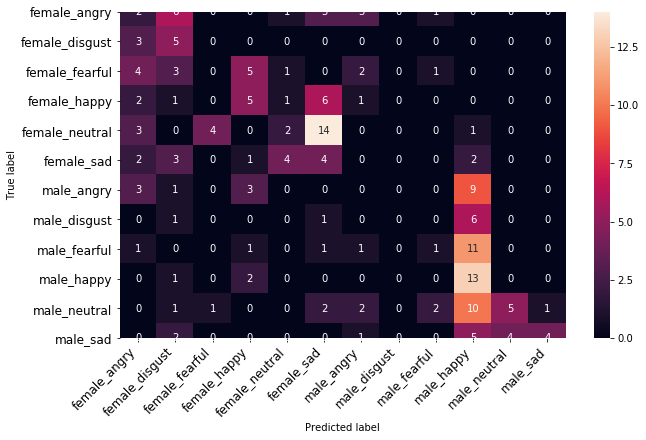

In [71]:
df_cm = pd.DataFrame(c_matrix, index=class_names, columns=class_names)

plt.figure(figsize=(10,6))
try:
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
except ValueError:
    raise ValueError("Confusion matrix values must be integers.")


heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=12)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=12)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [72]:
import pickle
filename = 'E:/NYU_Classes/Project/Models/Ravdess_12class_HMM.sav'
pickle.dump(hmm_models, open(filename, 'wb'))